In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display, display_markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import subprocess as sp
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import bambi
from copy import deepcopy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 150

from subs2vec.utensils import log_timer
from subs2vec.vecs import Vectors
from subs2vec.neighbors import compute_nn

import logging
logging.getLogger().setLevel(logging.WARNING)

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

def norm(x):
    return x / np.linalg.norm(x, 2)

def standardize(x):
    return (x - x.mean()) / x.std()

sns.set(style='whitegrid')
pd.options.mode.chained_assignment = None

# Loading and preparing data

In [2]:
df_joint = pd.read_csv('data/data_plus_predictors.tsv', sep='\t')
display(df_joint)

,index,group,dimension,pp_id,color,rating,experiment,self_vs_other,art,fiction,...,sighted,group_eff,group_z,original,replication_1,replication_2,other,self,self_vs_other_eff,self_vs_other_z
0,0,sighted,cold-hot,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
1,1,sighted,ripe-unripe,sighted_1,white,7,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
2,2,sighted,new-old,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
3,3,sighted,submissive-aggressive,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
4,4,sighted,selfless-jealous,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42975,28507,sighted,light-heavy,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42976,28508,sighted,relaxed-tense,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42977,28509,sighted,alive-dead,sighted_68129,red,6,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42978,28510,sighted,fast-slow,sighted_68129,red,3,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199


# Differences in color semantics between sighted and blind in original Saysani data
This model includes word frequency and concreteness of the dimension words as nuisance predictors. It also includes random intercepts and slopes (for the variables that vary by item) by participant, as well as random intercepts by semantic dimension and color (separated out for the blind and sighted groups, as well).  
All variables are entered as interactions with the group (i.e. sighted vs. blind) effect, so that we can easily pull out conditional effects separated out by group.

In [3]:
m = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_subs_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_subs_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[df_joint['experiment'] == 'original']
)
r = m.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 8,620.4
[INFO] Finished [100%]: Average Loss = 8,620.4
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_subs_z, group_eff:cosine_subs_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_subs_z|pp_id_sigma, cosine_subs_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_subs_z, group_eff:cosine_subs_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 249 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 249 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
blind:cosine_subs_z,0.317,0.053,0.218,0.421,0.001,0.001,3014.0,2925.0,1.0
sighted:cosine_subs_z,0.567,0.041,0.487,0.645,0.001,0.000,4493.0,3321.0,1.0


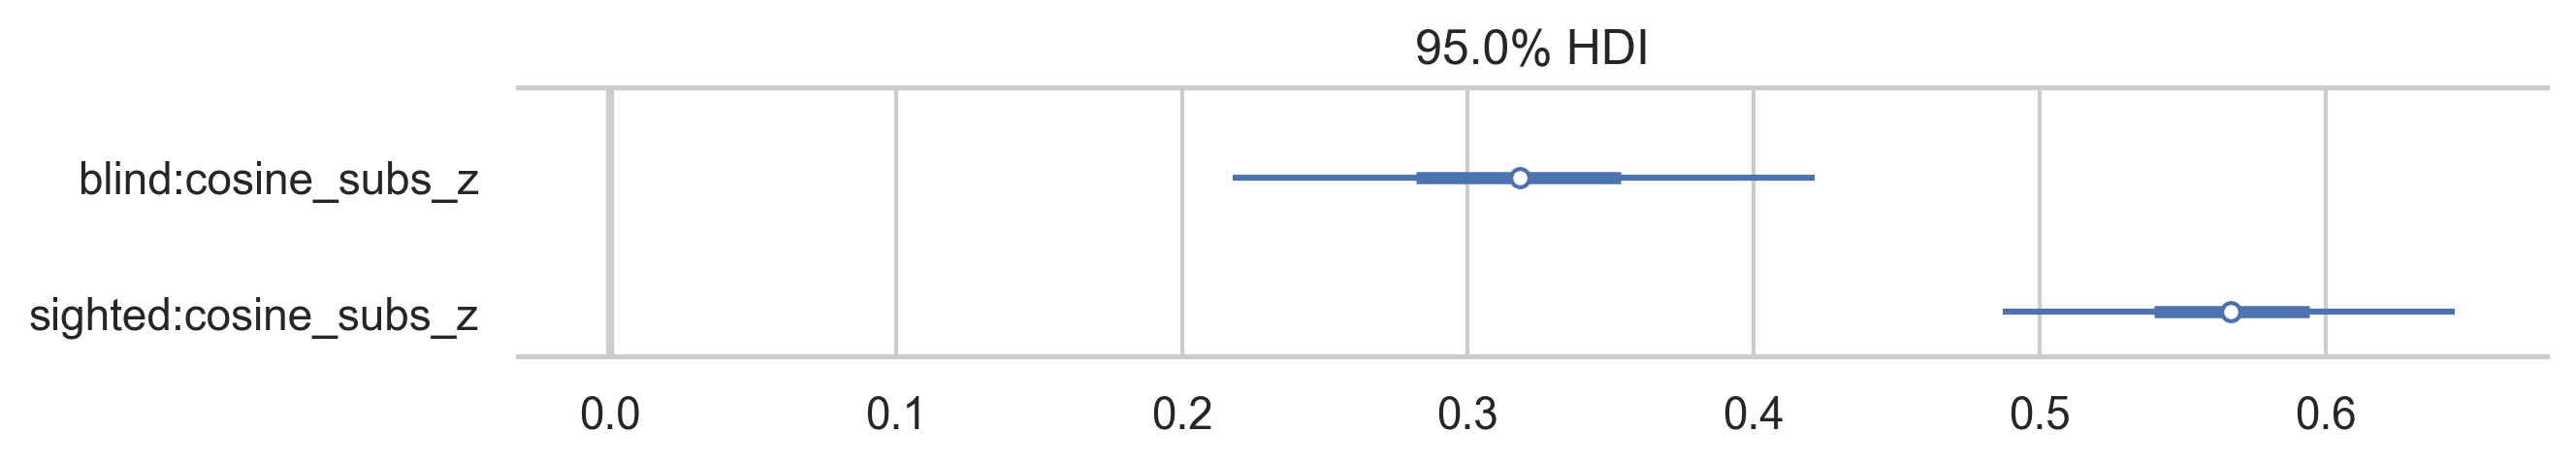

In [4]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace = deepcopy(r.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_subs_z'] = trace['cosine_subs_z'] - trace['group_eff:cosine_subs_z']
    # effect of cosine in sighted group across both experiments
trace['sighted:cosine_subs_z'] = trace['cosine_subs_z'] + trace['group_eff:cosine_subs_z']

varnames = ['blind:cosine_subs_z', 'sighted:cosine_subs_z']
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);
display(az.summary(trace, hdi_prob=.95, var_names=varnames))

## With Small World of Words cue-response scores added as covariate

In [5]:
m_orig = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_subs_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_subs_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[df_joint['experiment'] == 'original']
)
r_orig = m_orig.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 8,672
[INFO] Finished [100%]: Average Loss = 8,672
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_subs_z, group_eff:cosine_subs_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_subs_z|pp_id_sigma, cosine_subs_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_subs_z, group_eff:cosine_subs_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_o

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 276 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 276 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
blind:cosine_subs_z,0.247,0.052,0.149,0.348,0.001,0.001,2576.0,3167.0,1.0
sighted:cosine_subs_z,0.492,0.040,0.416,0.570,0.001,0.000,4377.0,3081.0,1.0


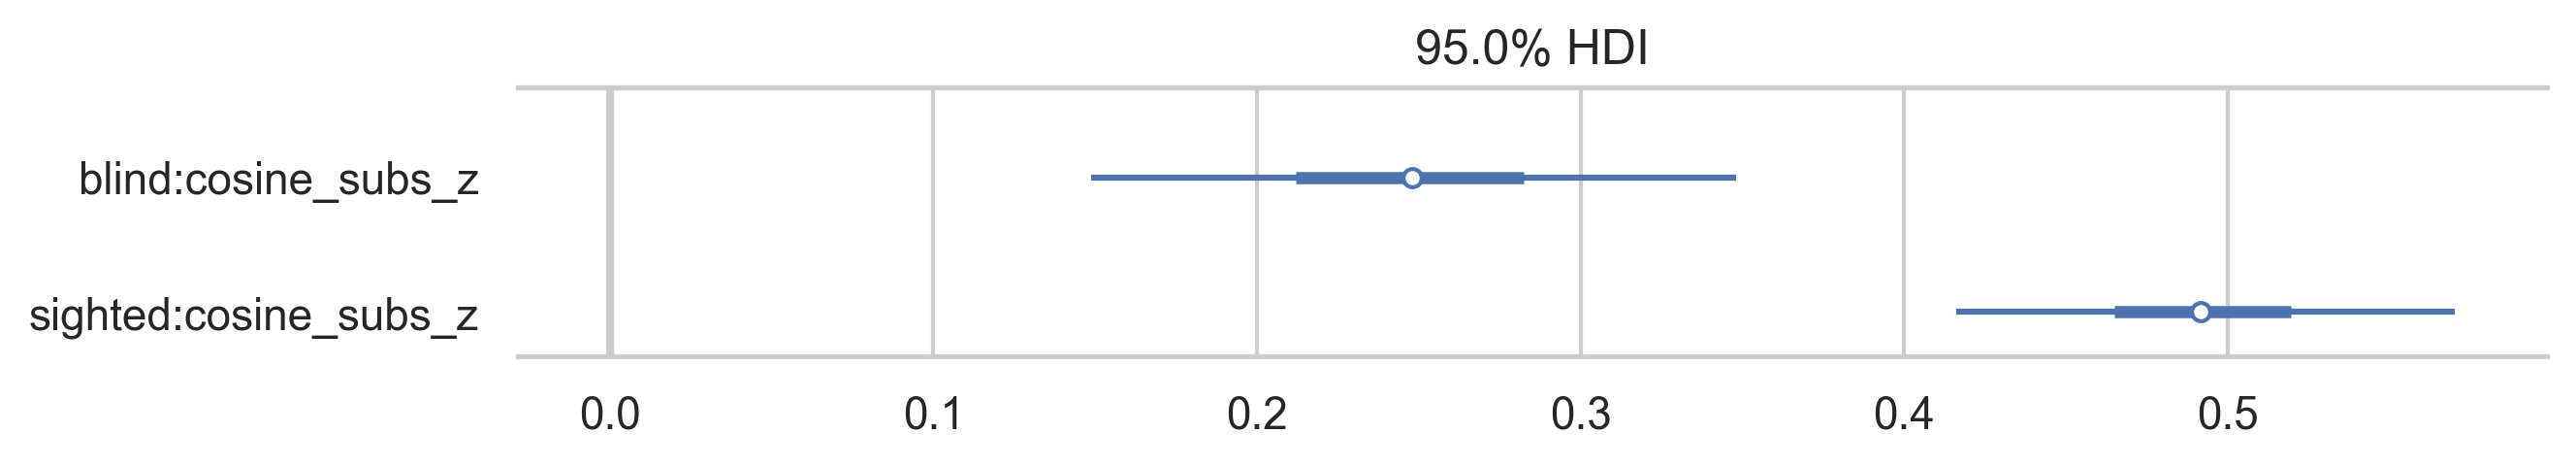

In [6]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace = deepcopy(r_orig.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_subs_z'] = trace['cosine_subs_z'] - trace['group_eff:cosine_subs_z']
    # effect of cosine in sighted group across both experiments
trace['sighted:cosine_subs_z'] = trace['cosine_subs_z'] + trace['group_eff:cosine_subs_z']

varnames = ['blind:cosine_subs_z', 'sighted:cosine_subs_z']
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);
display(az.summary(trace, hdi_prob=.95, var_names=varnames))

## Visual model diagnostics
R-hat and other Markov chain diagnostics looked good, but it's still worth doing a few quick visual model checks.
### Quick look at the trace plots
We want all the Markov chains for a single variable to look lined up in the density plot on the left, but nice and fuzzy (i.e. not autocorrelated) on the right.

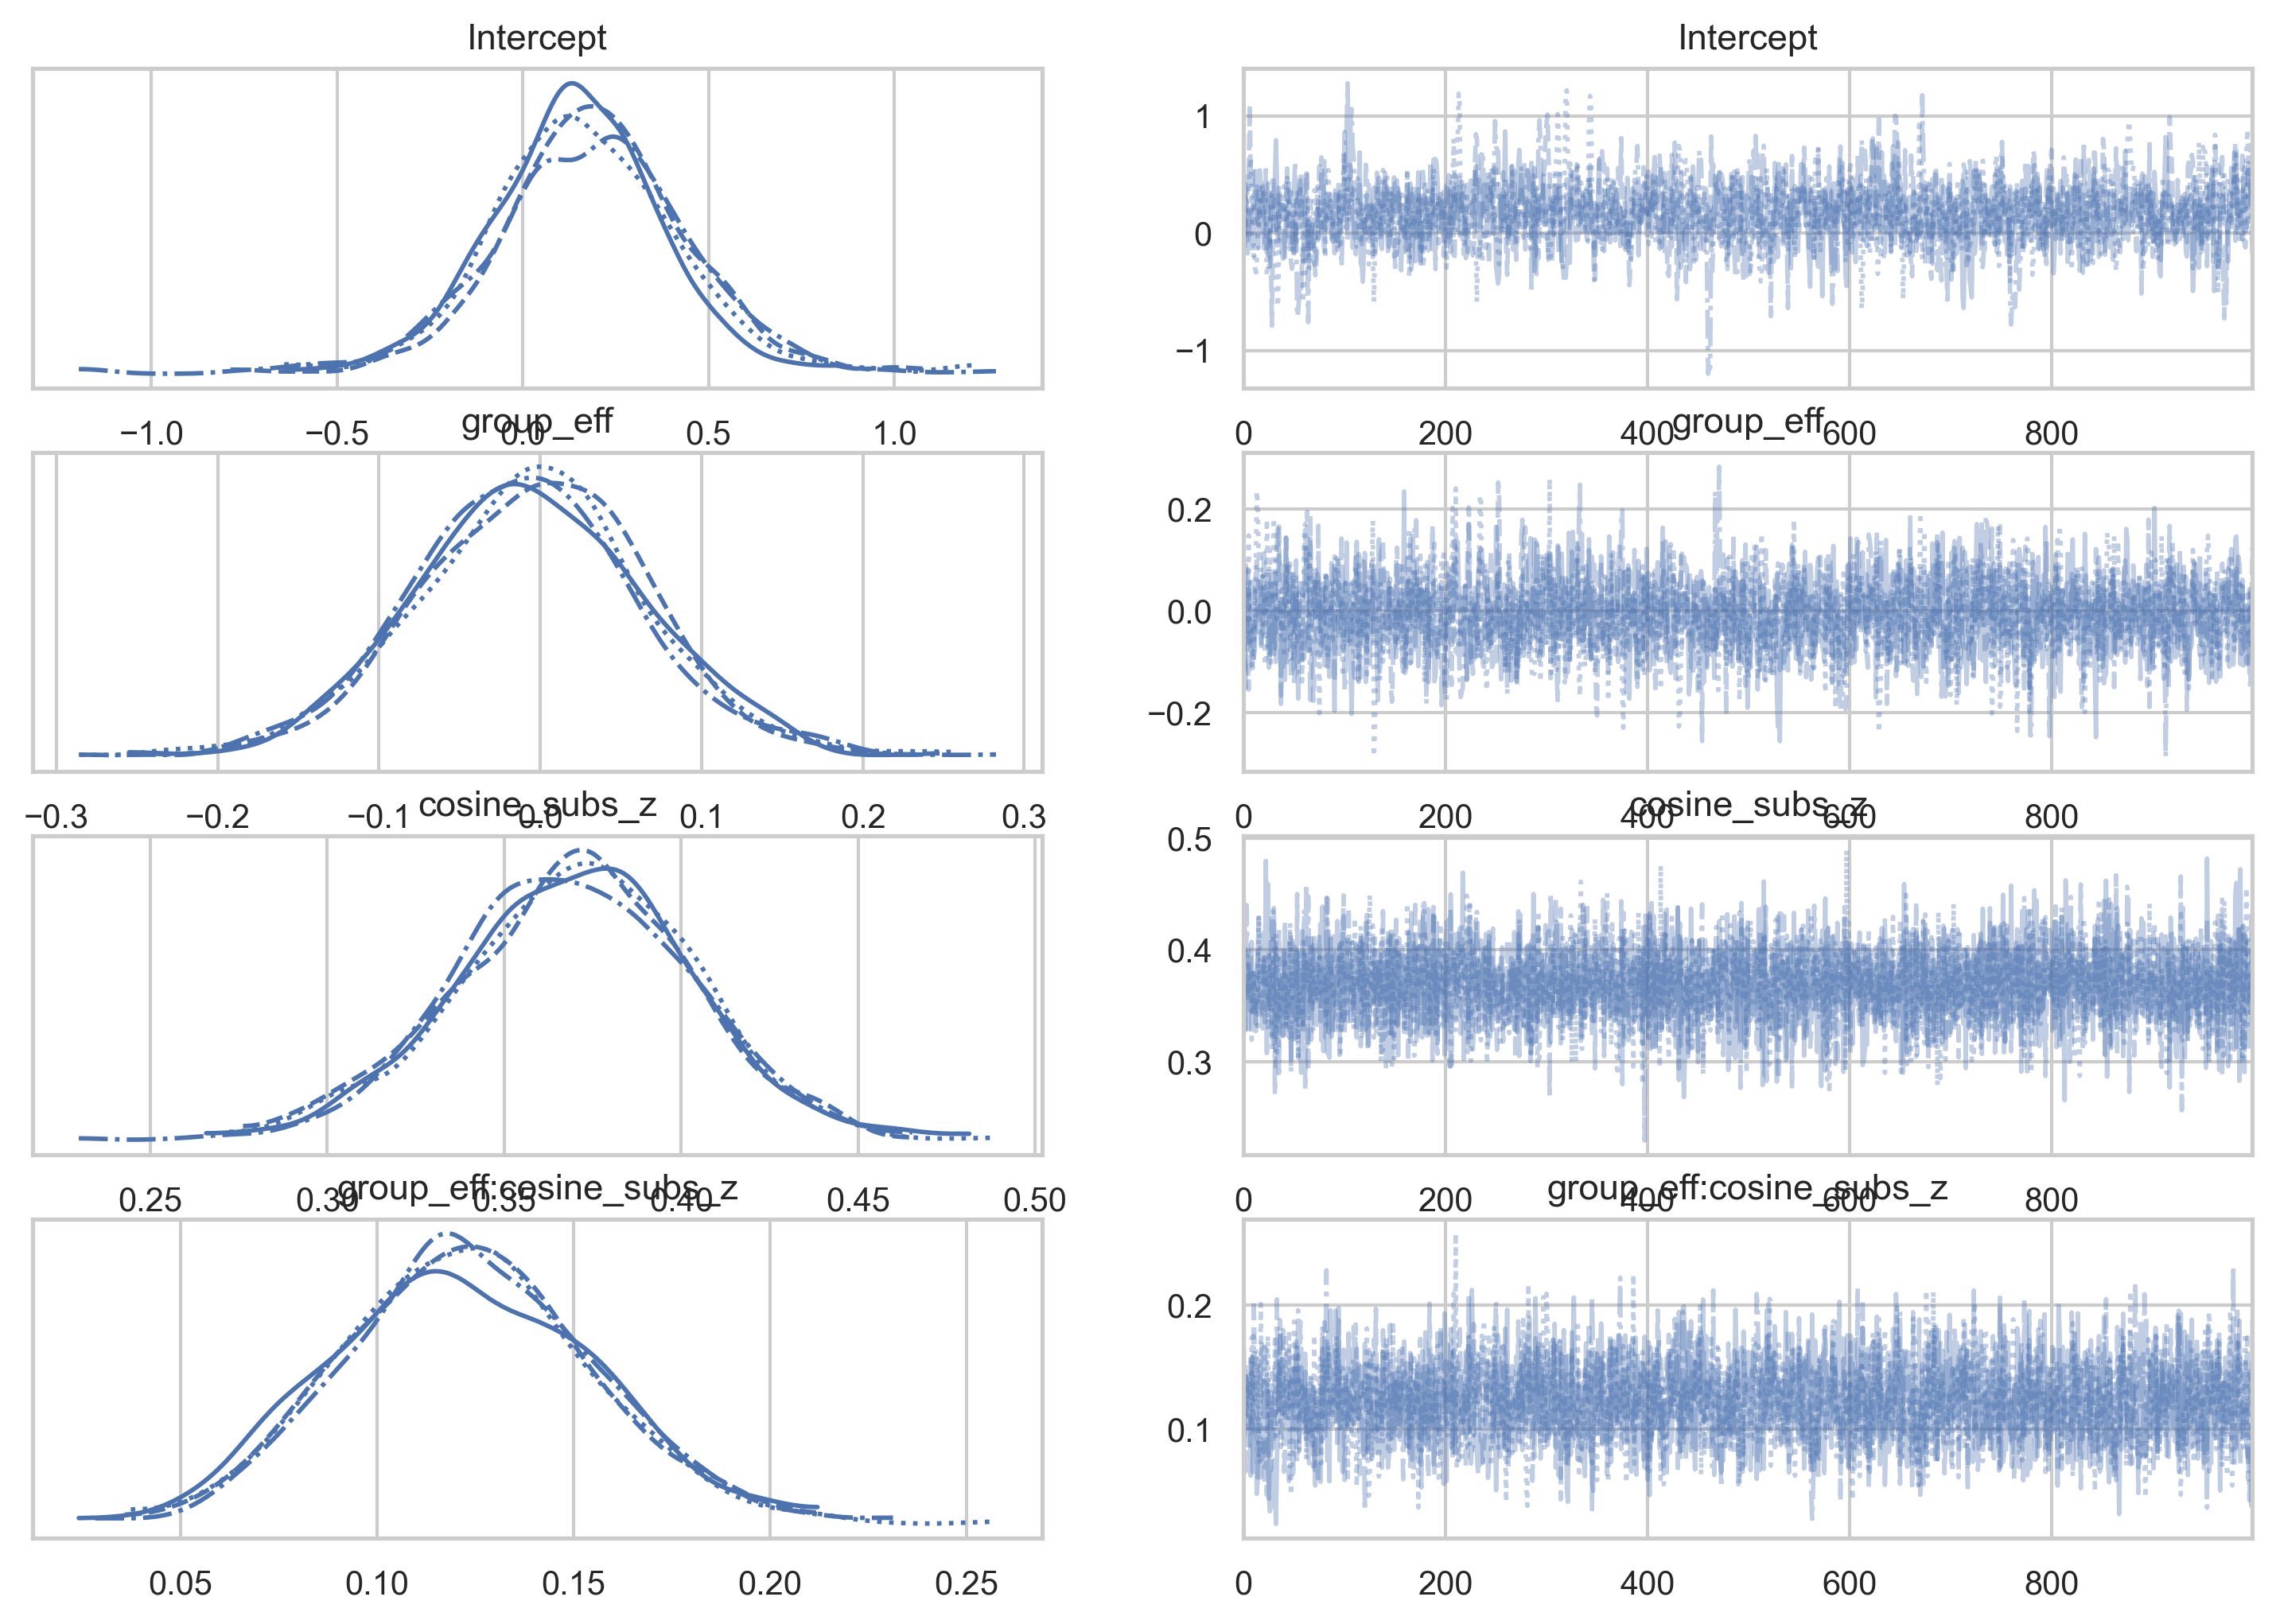

In [7]:
g = az.plot_trace(r_orig, var_names=['Intercept', 'group_eff', 'cosine_subs_z', 'group_eff:cosine_subs_z'])

### Cumulative posterior predictive check
Check if the model's predictions line up with the predictions in our observed data (i.e. there are no weird biases etc.)

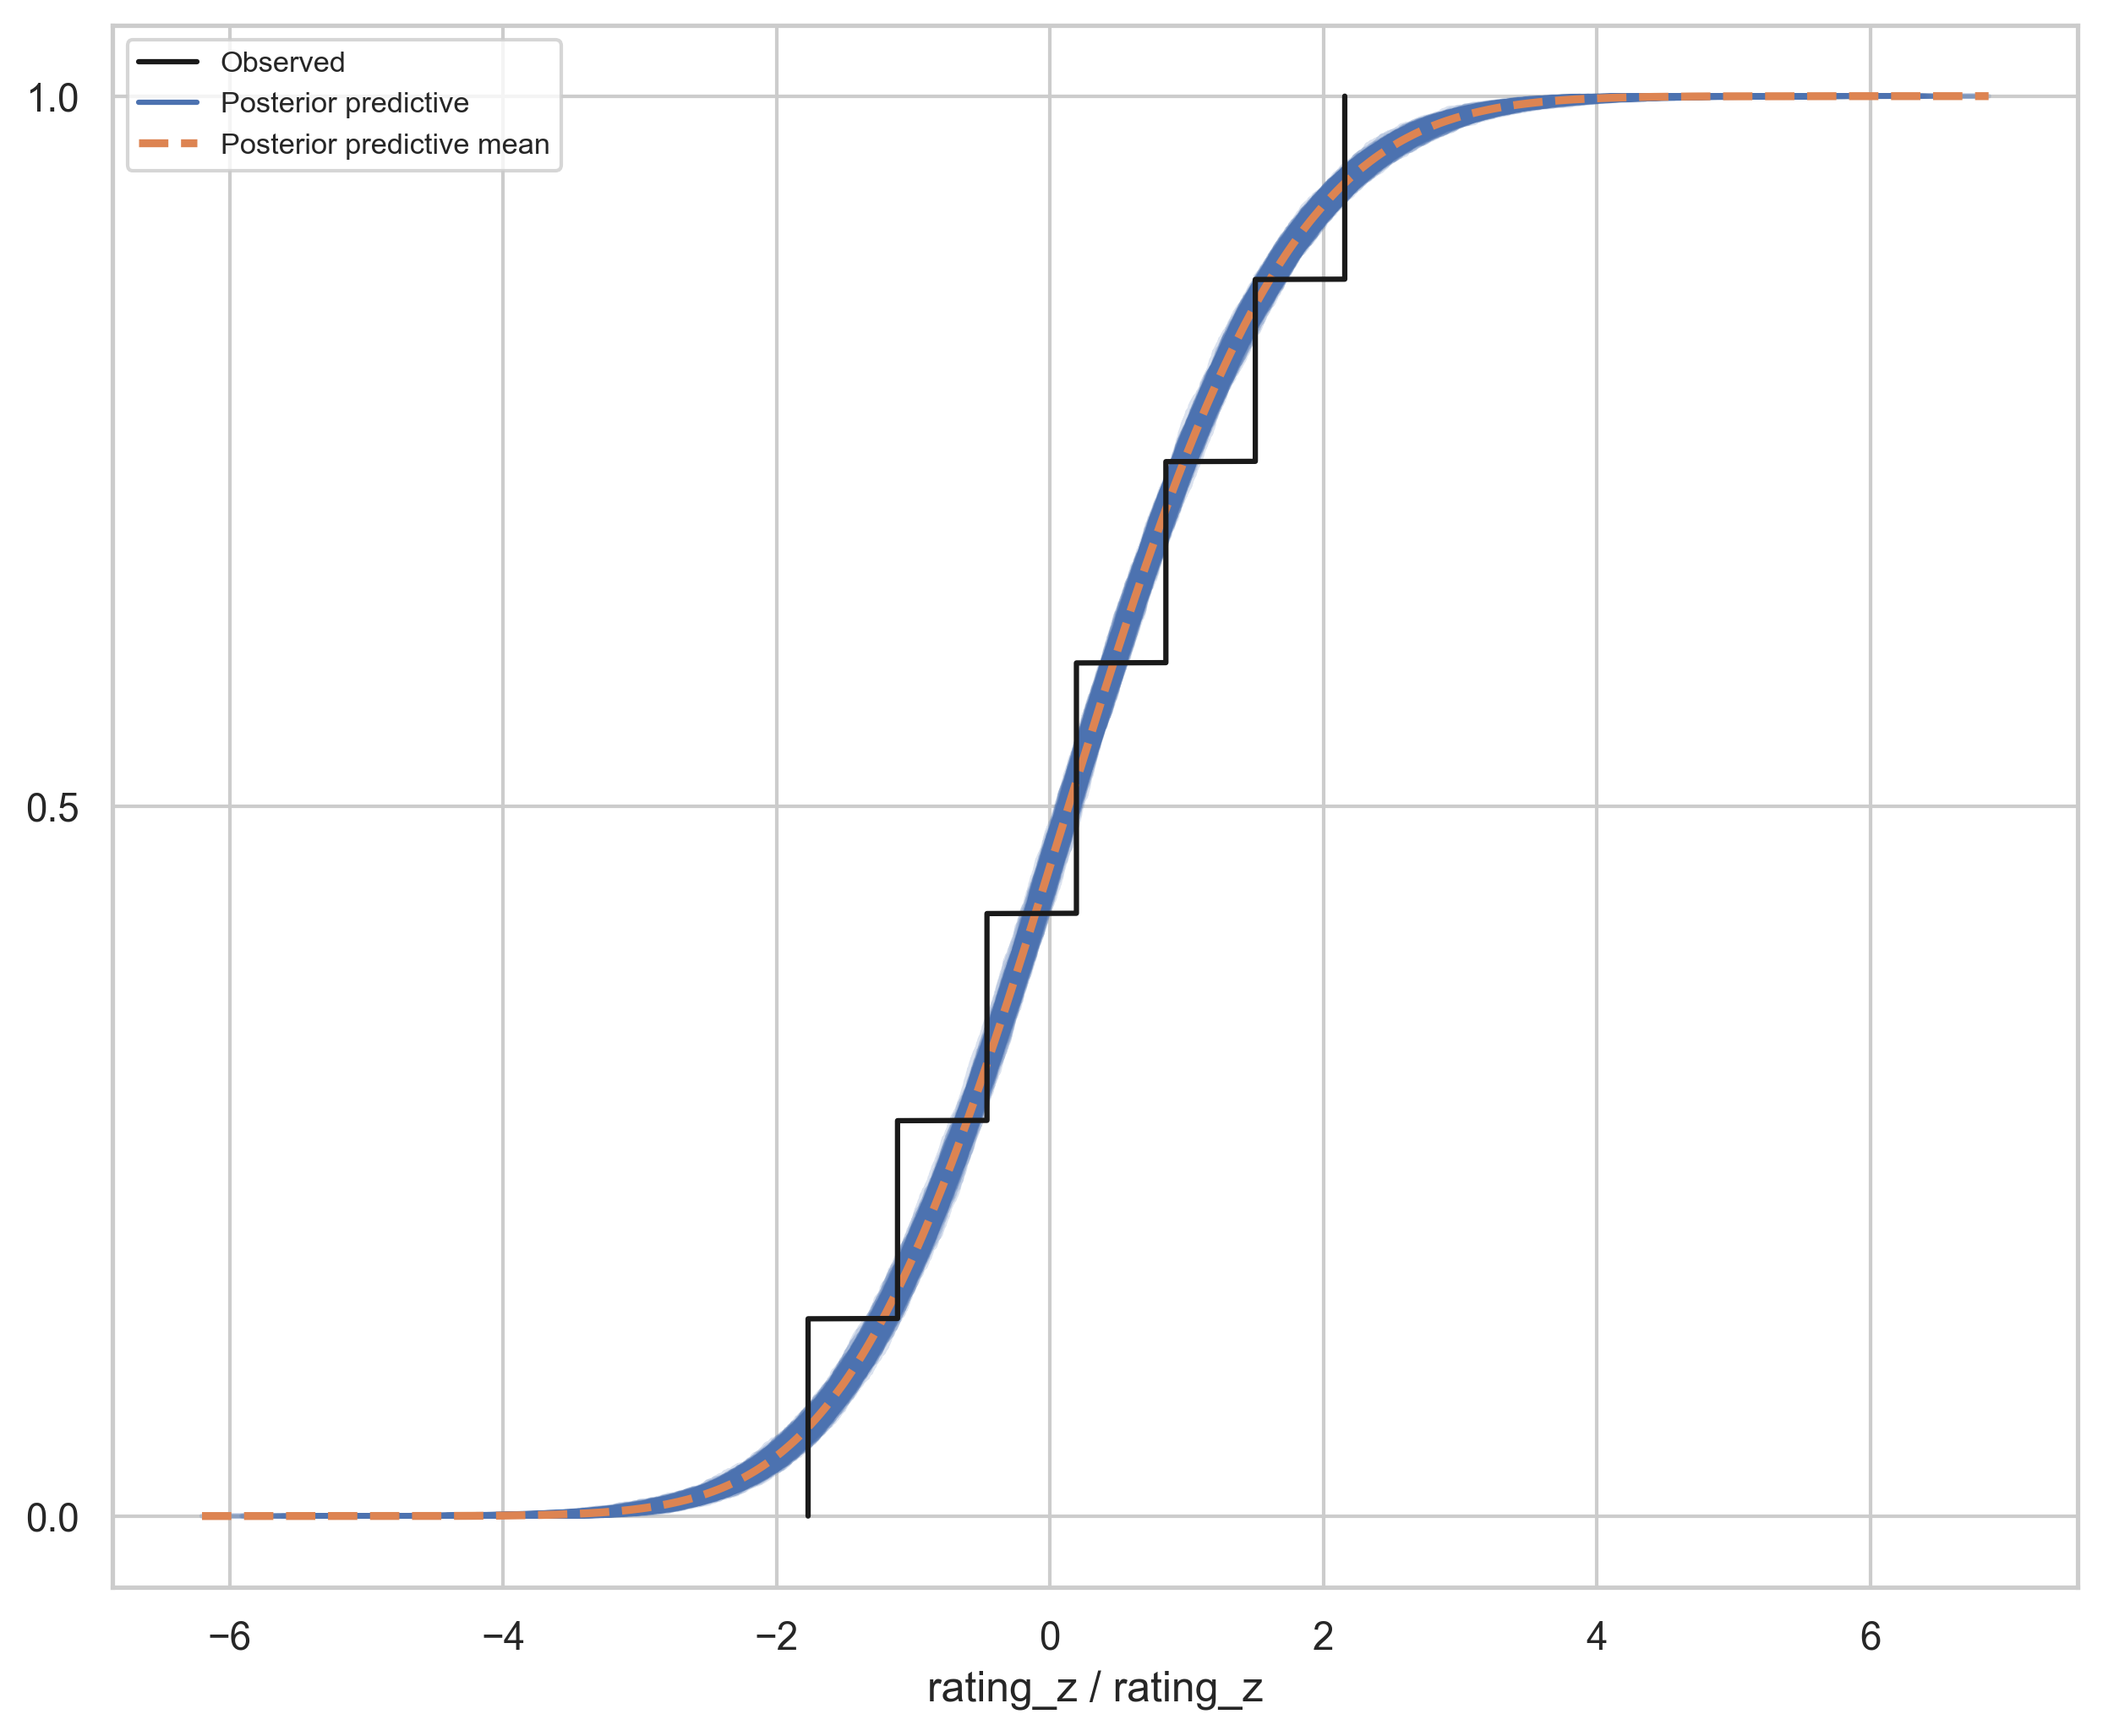

In [8]:
m_orig.predict(r_orig, kind='pps')
g = az.plot_ppc(r_orig, kind='cumulative')

# Convert notebook to html

In [9]:
convert_notebook('experiment_1')

Jupyter notebook `experiment_1` converted successfully.